# Lista de exercícios de Transfer Learning

<br/>**Disciplina**: Introdução à Redes Neurais Profundas 2018/1
<br/>**Professor**: Jorge Leonid Aching Samatelo

 **Alunos**:  Marcos A. Spalenza

## Sobre a lista
 * A lista dever ser feita utilizando os códigos disponíveis em : [Transfer Learning](https://github.com/clebeson/Deep_Learning/tree/master/Transfer-Learning).
 
 * Tais códigos vêm acompanhados de um tutorial de como aplicar transfer learning para o problema de classificação de imagens utilizando a arquitetura da rede VGG16.
 * O código foi feito pensando na facilidade de apredizado do assunto e de sua adaptação para a aplicação em outros problemas. Sendo assim, aconselho fortemente o entendimento de toda a estrutura do código a fim de facilitar a sua utilização em trabalhos futuros.
 

In [16]:
! ls
! rm -r ./*
! ls

rm: cannot remove './*': No such file or directory


In [15]:
%matplotlib inline  
import pickle
import numpy as np
import os
from urllib.request import urlretrieve
import tarfile
import zipfile
import sys
import tensorflow as tf
import numpy as np
from time import time
import skimage as sk
from skimage import transform
from skimage import util
import random
import math
import os.path
from random import shuffle
import logging
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from google.colab import files
from itertools import product
!pip install googledrivedownloader
logging.getLogger("tensorflow").setLevel(logging.ERROR)

"""---
### Class that defines the principals hyperparameters used by the model
"""

class Hyperparameters:
    def __init__(self):
        self.image_size = 32
        self.image_channels = 3
        self.num_classes = 10
        self.initial_learning_rate = 1e-4
        self.decay_steps = 1e3
        self.decay_rate = 0.98
        self.cut_layer = "pool5"
        self.hidden_layers = [512]
        self.batch_size = 128
        self.num_epochs = 200
        self.check_points_path= "./tensorboard/cifar10_vgg16"
        self.keep = 1.0
        self.fine_tunning = False
        self.bottleneck = True

class utils:
    def get_or_generate_bottleneck( sess, model, file_name, dataset, labels, batch_size = 128):

        path_file = os.path.join("./data_set",file_name+".pkl")
        if(os.path.exists(path_file)):
            print("Loading bottleneck from \"{}\" ".format(path_file))
            with open(path_file, 'rb') as f:
                return pickle.load(f)

        bottleneck_data = []
        original_labels = []

        print("Generating Bottleneck \"{}.pkl\" ".format(file_name) )
        count = 0
        amount = len(labels) // batch_size
        indices = list(range(len(labels)))
        for i in range(amount+1):
            if (i+1)*batch_size < len(indices):
                indices_next_batch = indices[i*batch_size: (i+1)*batch_size]
            else:
                indices_next_batch = indices[i*batch_size:]
            batch_size = len(indices_next_batch)

            data = dataset[indices_next_batch]
            label = labels[indices_next_batch]
            input_size = np.prod(model["bottleneck_tensor"].shape.as_list()[1:])
            tensor = sess.run(model["bottleneck_tensor"], feed_dict={model["images"]:data, model["bottleneck_input"]:np.zeros((batch_size,input_size)), model["labels"]:label,model["keep"]:1.0})
            for t in range(batch_size):
                bottleneck_data.append(np.squeeze(tensor[t]))
                original_labels.append(np.squeeze(label[t]))
          
        bottleneck = {
            "data":np.array(bottleneck_data),
            "labels":np.array(original_labels)
        } 

        with open(path_file, 'wb') as f:
            pickle.dump(bottleneck, f)


        print("Done")   

        return bottleneck



    def get_data_set(name="train"):
        x = None
        y = None
        folder_name = 'cifar_10'
        main_directory = "./data_set"
        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

        utils.maybe_download_and_extract(url, main_directory,folder_name, "cifar-10-batches-py")


        f = open(os.path.join(main_directory,folder_name,"batches.meta"), 'rb')
        f.close()

        if name is "train":
            for i in range(5):
                f = open('./data_set/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
                datadict = pickle.load(f, encoding='latin1')
                f.close()

                _X = datadict["data"]
                _Y = datadict['labels']

                _X = np.array(_X, dtype=float) / 255.0
                _X = _X.reshape([-1, 3, 32, 32])
                _X = _X.transpose([0, 2, 3, 1])

                if x is None:
                    x = _X
                    y = _Y
                else:
                    x = np.concatenate((x, _X), axis=0)
                    y = np.concatenate((y, _Y), axis=0)

        elif name is "test":
            f = open('./data_set/'+folder_name+'/test_batch', 'rb')
            datadict = pickle.load(f, encoding='latin1')
            f.close()

            x = datadict["data"]
            y = np.array(datadict['labels'])

            x = np.array(x, dtype=float) / 255.0
            x = x.reshape([-1, 3, 32, 32])
            x = x.transpose([0, 2, 3, 1])

        return x, utils._dense_to_one_hot(y)


    def _dense_to_one_hot( labels_dense, num_classes=10):
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

        return labels_one_hot

    def maybe_download_and_extract( url, main_directory,filename, original_name):
        def _print_download_progress( count, block_size, total_size):
            pct_complete = float(count * block_size) / total_size
            msg = "\r --> progress: {0:.1%}".format(pct_complete)
            sys.stdout.write(msg)
            sys.stdout.flush()
          
        if not os.path.exists(main_directory):
            os.makedirs(main_directory)
            url_file_name = url.split('/')[-1]
            zip_file = os.path.join(main_directory,url_file_name)
            print("Downloading ",url_file_name)

            try:
                file_path, _ = urlretrieve(url=url, filename= zip_file, reporthook=_print_download_progress)
            except:
                os.system("rm -r "+main_directory)
                print("An error occurred while downloading: ",url)

                if(original_name == 'vgg16-20160129.tfmodel'):
                    print("This could be for a problem with github. We will try downloading from the Google Drive")
                    from google_drive_downloader import GoogleDriveDownloader as gdd

                    gdd.download_file_from_google_drive(file_id='1xJZDLu_TK_SyQz-SaetAL_VOFY7xdAt5', dest_path='./models/vgg16-20160129.tfmodel', unzip=False)
                else: 
                    print("This could be for a problem with the storage site. Try again later")
                return

            print("\nDownload finished.")
            if file_path.endswith(".zip"):
                print( "Extracting files.")

                zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
            elif file_path.endswith((".tar.gz", ".tgz")):
                print( "Extracting files.")
                tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
                os.remove(file_path)

            os.rename(os.path.join(main_directory,original_name), os.path.join(main_directory,filename))
            print("Done.")
     
    def data_augmentation(images, labels):
        def random_rotation(image_array):
            # pick a random degree of rotation between 25% on the left and 25% on the right
            random_degree = random.uniform(-15, 15)
            return sk.transform.rotate(image_array, random_degree)

        def random_noise(image_array):
            # add random noise to the image
            return sk.util.random_noise(image_array)

        def horizontal_flip(image_array):
            # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
            return image_array[:, ::-1]

        print("Augmenting data...")
        aug_images = []
        aug_labels = []

        aug_images.extend( list(map(random_rotation, images)) )
        aug_labels.extend(labels)
        aug_images.extend( list(map(random_noise,    images)) )
        aug_labels.extend(labels)
        aug_images.extend( list(map(horizontal_flip, images)) )
        aug_labels.extend(labels)


        return np.array(aug_images), np.array(aug_labels)

    def generate_confusion_matrix( predictions, class_names):
        def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
            if normalize:
                cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                print("Normalized confusion matrix")
            else:
                print('Confusion matrix, without normalization')

            print(cm.shape)

            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            
            tick_marks = np.arange(len(classes))
           
      
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)

            fmt = '.2f' if normalize else 'd'
            thresh = cm.max() / 2.
            symbol = "%" if normalize else ""
            for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt)+symbol,
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

            plt.tight_layout()
            plt.ylabel('Real')
            plt.xlabel('Predicted')

        cnf_matrix = confusion_matrix(predictions["labels"],predictions["classes"])
        np.set_printoptions(precision=2)
        
        plt.figure(figsize=(10,7))
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                            title='Normalized confusion matrix')
        plt.grid('off')

        plt.show()

In [ ]:
def get_vgg16(input_images, cut_layer = "pool5", scope_name = "vgg16", fine_tunning = False):  
 
    file_name = 'vgg16-20160129.tfmodel'
    main_directory = "./models/"

    vgg_path = os.path.join(main_directory,file_name)
    if not os.path.exists(vgg_path):
        vgg16_url = "https://media.githubusercontent.com/media/pavelgonchar/colornet/master/vgg/tensorflow-vgg16/vgg16-20160129.tfmodel"
        utils.maybe_download_and_extract(vgg16_url, main_directory, file_name, file_name)


    with open(vgg_path, mode='rb') as f:
        content = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(content)
        graph_def = tf.graph_util.extract_sub_graph(graph_def, ["images", cut_layer])
        tf.import_graph_def(graph_def, input_map={"images": input_images})
    del content

    graph = tf.get_default_graph()
    vgg_node = "import/{}:0".format(cut_layer)


    vgg_trained_model = graph.get_tensor_by_name("{}/{}".format(scope_name, vgg_node) )

    if not fine_tunning:
        print("Stopping gradient")
        vgg_trained_model = tf.stop_gradient(vgg_trained_model) #Just use it in case of transfer learning without fine tunning

    return vgg_trained_model, graph

def transfer_learning_model(params = None, fine_tunning = False, bottleneck = False):
   
    if params is None:
       params = Hyperparameters()
      
    with tf.name_scope('placeholders_variables'):
        input_images = tf.placeholder(tf.float32, shape=[None,params.image_size, params.image_size, params.image_channels], name='input')
        labels = tf.placeholder(tf.float32, shape=[None, params.num_classes], name='labels')
        dropout_keep  =  tf.placeholder(tf.float32, name='dropout_keep')
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(params.initial_learning_rate, global_step, params.decay_steps,params.decay_rate, staircase=True)

    with tf.name_scope('vgg16'):
        vgg16_out,_ = get_vgg16(input_images=input_images,cut_layer = params.cut_layer, fine_tunning = fine_tunning)

    with tf.name_scope("flatten"):
        flatten = tf.layers.flatten(vgg16_out, name="flatten")
    
    if (not fine_tunning) and bottleneck:
        out_list = flatten.shape.as_list()
        BOTTLENECK_TENSOR_SIZE = np.prod(out_list[1:]) # All input layer size, less the batch size
        with tf.name_scope('bottleneck'):
            bottleneck_tensor = flatten
            bottleneck_input = tf.placeholder(tf.float32,
            shape=[None, BOTTLENECK_TENSOR_SIZE],
            name='InputPlaceholder')

        with tf.name_scope('fully_conn'):
             logits = fc_model(bottleneck_input, params.hidden_layers) 

    else:
        with tf.name_scope('fully_conn'):
             logits = fc_model(flatten, params.hidden_layers) #Create a fully connected model that will be fed by the vgg16

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(regularize(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels), type_ = 2))
        tf.summary.scalar("loss", loss)

    with tf.name_scope('sgd'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    with tf.name_scope('train_accuracy'):
        acc = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        acc = tf.reduce_mean(tf.cast(acc, tf.float32))
        tf.summary.scalar("accuracy", acc)
   
    
    predictions = {
                "classes": tf.argmax(logits, 1),
                "probs" :  tf.nn.softmax(logits), 
                "labels": tf.argmax(labels, 1)
                }
    model = {
            "global_step": global_step,
            "images": input_images,
            "labels": labels,    
            "loss" : loss,
            "optimizer": optimizer,
            "accuracy": acc,
            "predictions":predictions,
            "keep": dropout_keep
        }

    if (not fine_tunning) and bottleneck:
        model.update({"bottleneck_tensor":bottleneck_tensor})
        model.update({"bottleneck_input":bottleneck_input})
          
    return model
        
def get_fc_weights(w_inputs, w_output, id=0):
    weight= tf.Variable(tf.truncated_normal([w_inputs, w_output]), name="{}/weight".format(id))
    bias =  tf.Variable(tf.truncated_normal([w_output]), name="{}/bias".format(id))
    return weight, bias  

def logits_layer(fc_layer, n_classes):
    out_shape = fc_layer.shape.as_list()
    w, b = get_fc_weights(np.prod(out_shape[1:]), n_classes, "logits/weight")
    logits = tf.add(tf.matmul(fc_layer, w), b, name="logits")
    return logits
      
def fc_layer(input_layer, number_of_units, keep = None, layer_id = "fc"):
    pl_list = input_layer.shape.as_list()
    input_size = np.prod(pl_list[1:])

    w, b = get_fc_weights(input_size, number_of_units, layer_id)  
    fc_layer = tf.matmul(input_layer, w, name="{}/matmul".format(layer_id))
    fc_layer = tf.nn.bias_add(fc_layer, b, name="{}/bias-add".format(layer_id))

    if keep is not None:
      fc_layer = tf.nn.dropout(fc_layer, keep, name="{}/dropout".format(layer_id))
    else:
      print("Dropout was disabled.")

    fc_layer = tf.nn.relu(fc_layer, name="{}/relu".format(layer_id))
    return fc_layer
      
def regularize(loss, type_ = 1, scale = 0.005, scope = None):
    if type == 1:
        regularizer = tf.contrib.layers.l1_regularizer( scale=scale, scope=scope)
    else:
        regularizer = tf.contrib.layers.l2_regularizer( scale=scale, scope=scope)

    weights = tf.trainable_variables() # all vars of your graph
    regularization_penalty = tf.contrib.layers.apply_regularization(regularizer, weights)
    regularized_loss = loss + regularization_penalty
    return regularized_loss

def fc_model(flatten, hidden_layers = [512], keep = None):
    fc = flatten
    id = 1
    for num_neurons in hidden_layers:
        fc = fc_layer(fc, num_neurons, keep,  "fc{}".format(id) )
        id = id+1

    logits = logits_layer(fc, params.num_classes)
    return logits

def create_monitored_session(model,iter_per_epoch, checkpoint_dir):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    sess = tf.train.MonitoredTrainingSession(checkpoint_dir=checkpoint_dir, save_checkpoint_secs=120, log_step_count_steps=iter_per_epoch, save_summaries_steps=iter_per_epoch, config=config) 
    return sess

In [ ]:
def test(sess, model,input_data_placeholder, data, labels, batch_size = 128):
    global_accuracy = 0
    predictions = { "classes":[], "probs":[], "labels":[] }

    size = len(data)//batch_size
    indices = list(range(len(data)))

    for i in range(size+1):

        begin = i*batch_size
        end = (i+1)*batch_size
        end = len(data) if end >= len(data) else end

        next_bach_indices = indices[begin:end]
        batch_xs = data[next_bach_indices]
        batch_ys = labels[next_bach_indices]

        pred = sess.run(model["predictions"],
            feed_dict={input_data_placeholder: batch_xs, model["labels"]: batch_ys, model["keep"]:1.0})

        predictions["classes"].extend(pred["classes"])
        predictions["probs"].extend(pred["probs"])
        predictions["labels"].extend(pred["labels"])


    correct = list (map(lambda x,y: 1 if x==y else 0, predictions["labels"] , predictions["classes"]))
    acc = np.mean(correct ) *100

    mes = "--> Test accuracy: {:.2f}% ({}/{})"
    print(mes.format( acc, sum(correct), len(data)))

    return predictions

In [ ]:
def train(params = None, use_data_aug=True):
    !rm -r ./tensorboard/cifar10_vgg16
    if params is None:
      params = Hyperparameters()
      
    tf.reset_default_graph()

    train_data, train_labels = utils.get_data_set("train")
    
    if use_data_aug:
        train_data, train_labels = utils.data_augmentation(train_data, train_labels)
    
    print(np.shape(train_data))
    test_data, test_labels = utils.get_data_set("test")  
    
    model = transfer_learning_model(params, params.fine_tunning, params.bottleneck)

    steps_per_epoch = int(math.ceil(len(train_data) /  params.batch_size))
    sess = create_monitored_session(model,steps_per_epoch, params.check_points_path)
    
    
    if (not params.fine_tunning) and params.bottleneck:
        indices = list( range(len(train_data)) )
        shuffle(indices)
        
        shuffled_data = train_data[indices]
        shuffled_labels = train_labels[indices]
        
        bottleneck_train = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_train".format(params.cut_layer), shuffled_data, shuffled_labels)
        bottleneck_test = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_test".format(params.cut_layer), test_data, test_labels)
        
        train_data, train_labels  = bottleneck_train["data"], bottleneck_train["labels"]
        test_data, test_labels = bottleneck_test["data"], bottleneck_test["labels"]
        del bottleneck_train, bottleneck_test
        
        input_data_placeholder = model["bottleneck_input"]
        
    else:
        input_data_placeholder = model["images"]
        
        
    
    indices = list( range(len(train_data)) )
    msg = "--> Global step: {:>5} - Last batch acc: {:.2f}% - Batch_loss: {:.4f} - ({:.2f}, {:.2f}) (steps,images)/sec"
    
    for epoch in range(params.num_epochs):
        start_time = time()
        
        print("\n*************************************************************")
        print("Epoch {}/{}".format(epoch+1,params.num_epochs))
        
        shuffle(indices)  
        for s in range(steps_per_epoch):
          
            indices_next_batch = indices[s *  params.batch_size : (s+1) * params.batch_size]
            batch_data = train_data[indices_next_batch]
            batch_labels = train_labels[indices_next_batch]
            _, batch_loss, batch_acc,step = sess.run(
                [model["optimizer"], model["loss"], model["accuracy"], model["global_step"],],
                feed_dict={input_data_placeholder: batch_data, model["labels"]: batch_labels, model["keep"]:params.keep})
            #print("loss", batch_loss)
            #print("acc", batch_acc)
        duration = time() - start_time
          
        print(msg.format(step,  batch_acc*100, batch_loss, (steps_per_epoch / duration), (steps_per_epoch*params.batch_size / duration) ))

        
        _ = test(sess, model, input_data_placeholder, test_data, test_labels )
    
    predictions = test(sess, model, input_data_placeholder, test_data, test_labels )

    sess.close()
    
    class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"] 
    utils.generate_confusion_matrix(predictions, class_names)

## Exe. 1
Obtenha o melhor resultado de classificação para o CIFAR10 utilizando a VGG16. Para isso, você poderá, além de variar os hiperparâmetros, escolher se utilizará ou não os regularizadores dropout, data augmentation, L1 e L2. 
*  **Obs.:** O *data augmentation* aumentará consideravelmente o consumo de memória RAM, o que poderá fazer com que o Colab desconecte a sua sessão.

Apresente os resultados na forma de uma medida de acurácia e uma matriz de confusão.  Além disso, responda às seguintes perguntas:
* ** Quais as suas conclusões ao treinar a rede com e sem uso do bottleneck?**
* ** Quais as suas conclusões em relação ao uso do fine tuning e do transfer learning?**
* ** A escolha das camadas de VGG16 influenciou o resultado? Por quê?**
* ** Qual a influência do hiperparâmetro "initial learning rate" na resolução do problema proposto?**



#Respostas:

*  Com o bottleneck a tendência é a aceleração do processo de treinamento com a redução do tempo de execução em cada batch. O processo ocorre mais rapidamente devido a aplicação do modelo pré-treinado diretamente nas camadas fully connected, funcionando como um classificador tradicional.

* Fine Tunning permite o reajuste do modelo de treinamento após análise do processo de classificação. Assim, o procedimento de Transfer Learning conecta a camada de convolução como um extrator de características, potencializada pela distribuição de todos os pesos em Fine Tunning.

* A definição da camada da VGG16 influenciou no resultado pela proximidade dos pesos ao dado de entrada. Quanto o corte é realizado mais próximo do layer de entrada de dados maior é a equivalência do dado com as características do dado. Por outro lado, quanto mais distante, mais abstrata é essa informação.

* O hiperparâmetro Initial Learning Rate define o aprendizado da rede. A learning rate inicial define qual é a perpectiva de aprendizado aplicada no Stochastic Gradient Descent - SGD. Com valores muito baixos a rede não vai alcançar boa variabilidade no processo de distribuição de pesos, ficando presa em uma "vizinhança". Com valores muito altos a rede ficará variando entre as vizinhanças com baixa probabilidade de alcançar resultados ótimos.

rm: cannot remove './tensorboard/cifar10_vgg16': No such file or directory
(50000, 32, 32, 3)
Stopping gradient
Dropout was disabled.
Loading bottleneck from "./data_set/bottleneck_vgg16_pool5_train.pkl" 
Loading bottleneck from "./data_set/bottleneck_vgg16_pool5_test.pkl" 

*************************************************************
Epoch 1/25
--> Global step:   390 - Last batch acc: nan% - Batch_loss: nan - (234.19, 29976.12) (steps,images)/sec
--> Test accuracy: 0.00% (0/16)

*************************************************************
Epoch 2/25
--> Global step:   781 - Last batch acc: nan% - Batch_loss: nan - (273.43, 34998.93) (steps,images)/sec
--> Test accuracy: 0.00% (0/16)

*************************************************************
Epoch 3/25
--> Global step:  1172 - Last batch acc: nan% - Batch_loss: nan - (277.65, 35539.19) (steps,images)/sec
--> Test accuracy: 6.25% (1/16)

*************************************************************
Epoch 4/25
--> Global step:  156

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix
(10, 10)


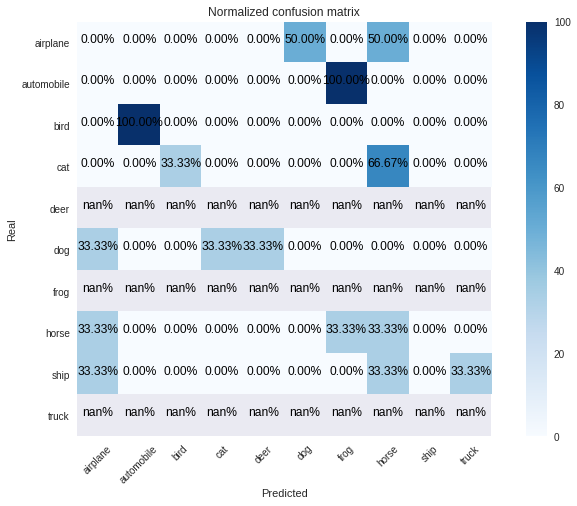

In [18]:
params = Hyperparameters()
params.num_epochs = 25
params.hidden_layers = [4096]
params.bottleneck = True
params.fine_tunning = False
train(params, use_data_aug=False)

rm: cannot remove './tensorboard/cifar10_vgg16': No such file or directory
 --> progress: 3.7% --> progress: 100.0%
Download finished.
Extracting files.
Done.
(50000, 32, 32, 3)
 --> progress: 99.6%Dropout was disabled.

*************************************************************
Epoch 1/25
--> Global step:   390 - Last batch acc: 33.75% - Batch_loss: 8914.4424 - (20.89, 2674.42) (steps,images)/sec
--> Test accuracy: 34.65% (3465/10000)

*************************************************************
Epoch 2/25
--> Global step:   781 - Last batch acc: 42.50% - Batch_loss: 8423.0811 - (24.89, 3186.13) (steps,images)/sec
--> Test accuracy: 43.25% (4325/10000)

*************************************************************
Epoch 3/25
--> Global step:  1172 - Last batch acc: 43.75% - Batch_loss: 7409.5186 - (24.83, 3177.86) (steps,images)/sec
--> Test accuracy: 46.78% (4678/10000)

*************************************************************
Epoch 4/25
--> Global step:  1563 - Last batch a

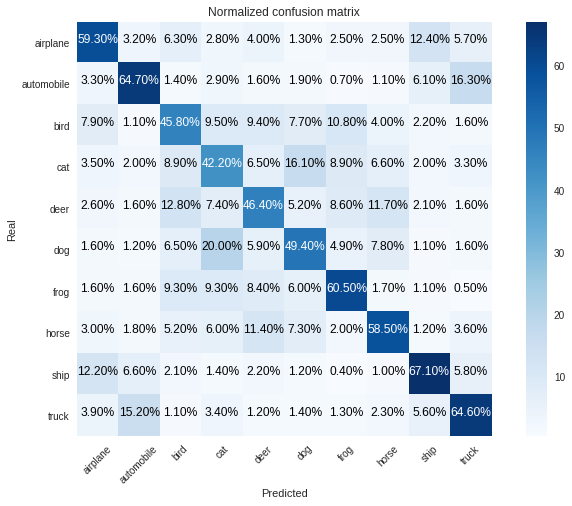

In [6]:
params = Hyperparameters()
params.num_epochs = 25
params.hidden_layers = [4096]
params.bottleneck = False
params.fine_tunning = True
train(params, use_data_aug=False)

rm: cannot remove './tensorboard/cifar10_vgg16': No such file or directory
(50000, 32, 32, 3)
Stopping gradient
Dropout was disabled.

*************************************************************
Epoch 1/25
--> Global step:   390 - Last batch acc: 10.00% - Batch_loss: 13589.4893 - (20.80, 2662.45) (steps,images)/sec
--> Test accuracy: 12.26% (1226/10000)

*************************************************************
Epoch 2/25
--> Global step:   781 - Last batch acc: 17.50% - Batch_loss: 12186.5703 - (24.30, 3110.21) (steps,images)/sec
--> Test accuracy: 15.06% (1506/10000)

*************************************************************
Epoch 3/25
--> Global step:  1172 - Last batch acc: 20.00% - Batch_loss: 11956.6982 - (24.18, 3095.41) (steps,images)/sec
--> Test accuracy: 18.89% (1889/10000)

*************************************************************
Epoch 4/25
--> Global step:  1563 - Last batch acc: 20.00% - Batch_loss: 11153.0283 - (24.20, 3097.29) (steps,images)/sec
--> Test 

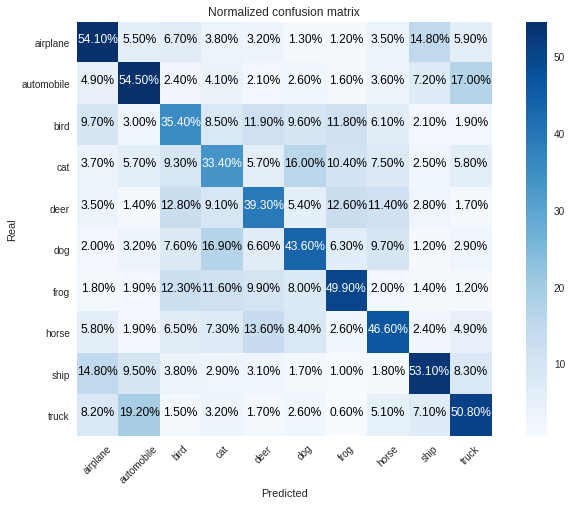

In [6]:
params = Hyperparameters()
params.num_epochs = 25
params.hidden_layers = [4096]
params.initial_learning_rate = 1e-5
params.bottleneck = False
train(params, use_data_aug=False)

Augmenting data...
(150000, 32, 32, 3)
Dropout was disabled.

*************************************************************
Epoch 1/25
--> Global step:  1171 - Last batch acc: 66.07% - Batch_loss: 26417.5742 - (28.85, 3693.37) (steps,images)/sec
--> Test accuracy: 66.80% (6680/10000)

*************************************************************
Epoch 2/25
--> Global step:  2343 - Last batch acc: 65.18% - Batch_loss: 19737.4824 - (29.68, 3798.96) (steps,images)/sec
--> Test accuracy: 69.12% (6912/10000)

*************************************************************
Epoch 3/25
--> Global step:  3515 - Last batch acc: 76.79% - Batch_loss: 14008.0693 - (29.51, 3777.03) (steps,images)/sec
--> Test accuracy: 69.97% (6997/10000)

*************************************************************
Epoch 4/25
--> Global step:  4687 - Last batch acc: 81.25% - Batch_loss: 10617.1035 - (29.65, 3794.78) (steps,images)/sec
--> Test accuracy: 71.87% (7187/10000)

******************************************

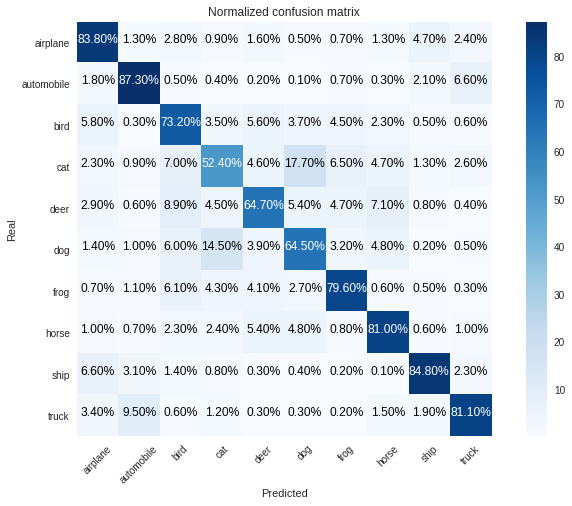

In [20]:
params = Hyperparameters()
params.num_epochs = 25
params.hidden_layers = [1024]
params.cut_layer = "pool4"
params.initial_learning_rate = 1e-3
params.fine_tunning = True
train(params)

rm: cannot remove './tensorboard/cifar10_vgg16': No such file or directory
Augmenting data...
(150000, 32, 32, 3)
Dropout was disabled.

*************************************************************
Epoch 1/25
--> Global step:  4687 - Last batch acc: 31.25% - Batch_loss: 1166.9277 - (54.67, 1749.30) (steps,images)/sec
--> Test accuracy: 53.78% (5378/10000)

*************************************************************
Epoch 2/25
--> Global step:  9375 - Last batch acc: 56.25% - Batch_loss: 727.6884 - (55.94, 1790.15) (steps,images)/sec
--> Test accuracy: 56.25% (5625/10000)

*************************************************************
Epoch 3/25
--> Global step: 14063 - Last batch acc: 62.50% - Batch_loss: 568.9585 - (55.81, 1786.07) (steps,images)/sec
--> Test accuracy: 56.33% (5633/10000)

*************************************************************
Epoch 4/25
--> Global step: 18751 - Last batch acc: 75.00% - Batch_loss: 549.9113 - (55.96, 1790.72) (steps,images)/sec
--> Test accur

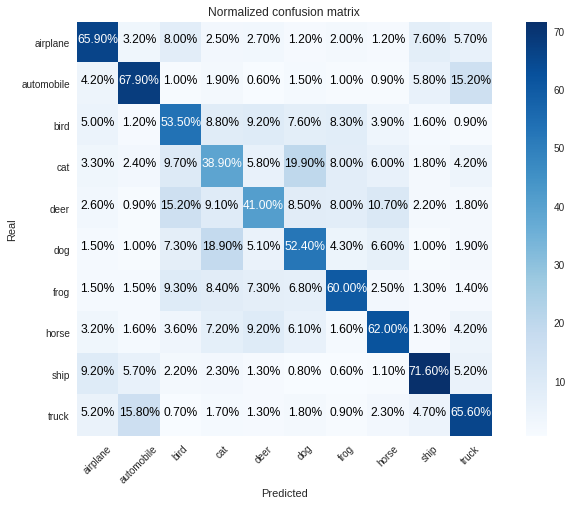

In [5]:
params = Hyperparameters()
params.num_epochs = 25
params.hidden_layers = [512]
params.initial_learning_rate = 1e-3
params.fine_tunning = True

train(params)

(50000, 32, 32, 3)
Dropout was disabled.

*************************************************************
Epoch 1/25
--> Global step:   390 - Last batch acc: 48.75% - Batch_loss: 2590.1804 - (22.09, 2827.44) (steps,images)/sec
--> Test accuracy: 50.56% (5056/10000)

*************************************************************
Epoch 2/25
--> Global step:   781 - Last batch acc: 58.75% - Batch_loss: 1672.9934 - (25.04, 3204.65) (steps,images)/sec
--> Test accuracy: 53.67% (5367/10000)

*************************************************************
Epoch 3/25
--> Global step:  1172 - Last batch acc: 47.50% - Batch_loss: 1958.8206 - (24.94, 3192.23) (steps,images)/sec
--> Test accuracy: 54.70% (5470/10000)

*************************************************************
Epoch 4/25
--> Global step:  1563 - Last batch acc: 65.00% - Batch_loss: 1533.3773 - (24.86, 3182.18) (steps,images)/sec
--> Test accuracy: 56.23% (5623/10000)

*************************************************************
Epoc

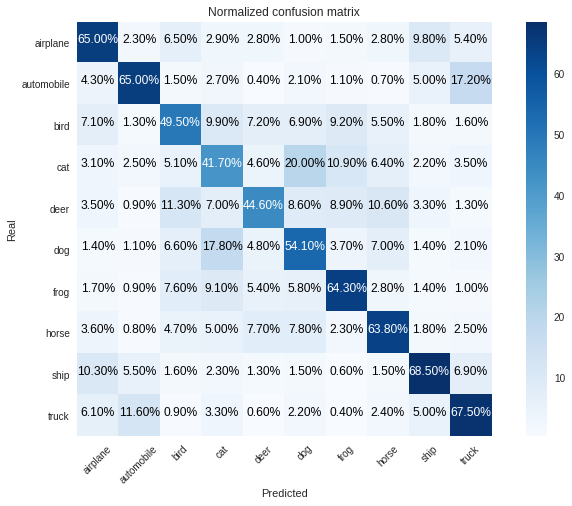

In [19]:
params = Hyperparameters()
params.num_epochs = 25
params.hidden_layers = [1024]
params.initial_learning_rate = 1e-3
params.fine_tunning = True

train(params,use_data_aug=False)

## Exe. 2
Usando a melhor configuração da rede obtidada na questão anterior, crie uma função que faça o teste de validação do modelo. 
Para isso, divida a base de treino em 45.000 imagens para treino e 5.000 para validação. 
A cada época a validação deverá ser feito, de maneira que ao alcançar um determinado limiar (decida qual o limiar) o treino deverá ser parado ([early stopping](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf)). 
Após isso, teste o modelo treinado e apresente o resultado na forma de uma acurácia e uma matriz de confusão. 

* **Quais as suas conclusões quanto ao procedimento utilizado em relação à questão anterior?**
* **Quais as vantagens na utilização da base validação, ao invés da base de teste, para o treinamento?**


#Respostas
* O processo de early stopping interrompe a execução na tentativa de evitar o overfitting, observando a disparidade entre as avaliações conhecidas (treino) e desconhecidas (validação).

* A base de validação é uma porção do dado de treinamento que é utilizado para validar os resultados alcançados durante o aprendizado do algoritmo. Com o modelo observado durante a calibração é possível reajustar, otimizar ou até finalizar (como o exemplo utilizado) o procedimento de treinamento para alcançar resultados esperados.

Dropout was disabled.

*************************************************************
Epoch 1/200
--> Test accuracy: 26.18% (1309/5000)
--> Global step:   351 - Last batch acc: 26.39% - Batch_loss: 71237.0391 - (24.11, 3085.61) (steps,images)/sec
--> Test accuracy: 26.19% (2619/10000)

*************************************************************
Epoch 2/200
--> Test accuracy: 40.00% (2000/5000)
--> Global step:   703 - Last batch acc: 38.89% - Batch_loss: 49687.6953 - (26.96, 3451.03) (steps,images)/sec
--> Test accuracy: 40.45% (4045/10000)

*************************************************************
Epoch 3/200
--> Test accuracy: 47.32% (2366/5000)
--> Global step:  1055 - Last batch acc: 47.22% - Batch_loss: 46603.5508 - (26.95, 3449.18) (steps,images)/sec
--> Test accuracy: 46.76% (4676/10000)

*************************************************************
Epoch 4/200
--> Test accuracy: 51.08% (2554/5000)
--> Global step:  1407 - Last batch acc: 63.89% - Batch_loss: 27391.6328 - (

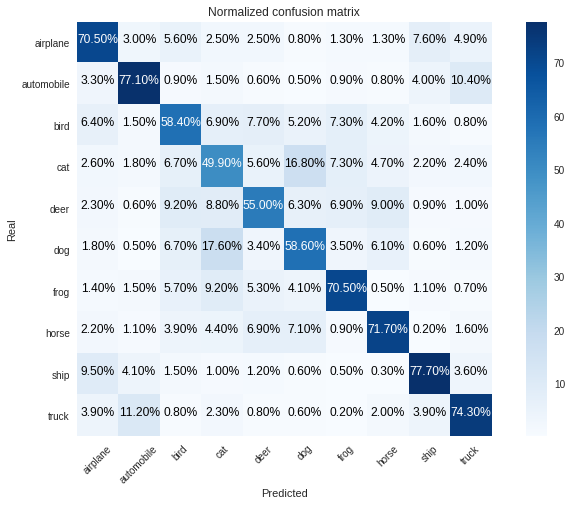

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

def test(sess, model,input_data_placeholder, data, labels, batch_size = 128):
    global_accuracy = 0
    predictions = { "classes":[], "probs":[], "labels":[] }

    size = len(data)//batch_size
    indices = list(range(len(data)))

    for i in range(size+1):

        begin = i*batch_size
        end = (i+1)*batch_size
        end = len(data) if end >= len(data) else end

        next_bach_indices = indices[begin:end]
        batch_xs = data[next_bach_indices]
        batch_ys = labels[next_bach_indices]

        pred = sess.run(model["predictions"],
            feed_dict={input_data_placeholder: batch_xs, model["labels"]: batch_ys, model["keep"]:1.0})

        predictions["classes"].extend(pred["classes"])
        predictions["probs"].extend(pred["probs"])
        predictions["labels"].extend(pred["labels"])


    correct = list (map(lambda x,y: 1 if x==y else 0, predictions["labels"] , predictions["classes"]))
    acc = np.mean(correct ) *100

    mes = "--> Test accuracy: {:.2f}% ({}/{})"
    print(mes.format( acc, sum(correct), len(data)))

    return predictions, acc
  
def train(params = None, use_data_aug=True, es_steps=3, validation = 0.1):
    !rm -r ./tensorboard/cifar10_vgg16
    if params is None:
      params = Hyperparameters()
      
    tf.reset_default_graph()

    train_data, train_labels = utils.get_data_set("train")
    
    if use_data_aug:
        train_data, train_labels = utils.data_augmentation(train_data, train_labels)
    

    test_data, test_labels = utils.get_data_set("test")  
    
    model = transfer_learning_model(params, params.fine_tunning, params.bottleneck)

    steps_per_epoch = int(math.ceil(len(train_data)*(1-validation)/  params.batch_size))
    sess = create_monitored_session(model,steps_per_epoch, params.check_points_path)
    
    sfs = StratifiedShuffleSplit(test_size = validation)
    
    train_idx, validation_idx = [(train_idx, validation_idx) for train_idx, validation_idx in sfs.split(train_data, train_labels)][0]
      

    if (not params.fine_tunning) and params.bottleneck:
        indices = list( range(len(train_data)) )

        shuffle(indices)

        shuffled_data = train_data[indices]
        shuffled_labels = train_labels[indices]

        bottleneck_train = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_train".format(params.cut_layer), shuffled_data, shuffled_labels)
        bottleneck_test = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_test".format(params.cut_layer), test_data, test_labels)

        train_data, train_labels  = bottleneck_train["data"], bottleneck_train["labels"]
        test_data, test_labels = bottleneck_test["data"], bottleneck_test["labels"]
        del bottleneck_train, bottleneck_test

        input_data_placeholder = model["bottleneck_input"]

    else:
        input_data_placeholder = model["images"]



    indices = train_idx
    msg = "--> Global step: {:>5} - Last batch acc: {:.2f}% - Batch_loss: {:.4f} - ({:.2f}, {:.2f}) (steps,images)/sec"

    best_acc = 0.0
    earlystop = 0

    for epoch in range(params.num_epochs):
        start_time = time()

        print("\n*************************************************************")
        print("Epoch {}/{}".format(epoch+1,params.num_epochs))

        shuffle(indices)  

        for s in range(steps_per_epoch):
            indices_next_batch = indices[s *  params.batch_size : (s+1) * params.batch_size]
            batch_data = train_data[indices_next_batch]
            batch_labels = train_labels[indices_next_batch]
            _, batch_loss, batch_acc,step = sess.run(
                [model["optimizer"], model["loss"], model["accuracy"], model["global_step"],],
                feed_dict={input_data_placeholder: batch_data, model["labels"]: batch_labels, model["keep"]:params.keep})

        _, val_acc = test(sess, model, input_data_placeholder, train_data[validation_idx], train_labels[validation_idx])

        if val_acc > best_acc:
            best_acc  = val_acc
            earlystop = 0
        else:
            earlystop += 1
            if earlystop == es_steps:
                print("Stopping train process at epoch "+str(epoch))
                break

        duration = time() - start_time

        print(msg.format(step,  batch_acc*100, batch_loss, (steps_per_epoch / duration), (steps_per_epoch*params.batch_size / duration) ))

        _ = test(sess, model, input_data_placeholder, test_data, test_labels )

    predictions, acc = test(sess, model, input_data_placeholder, test_data, test_labels )

    sess.close()
    
    class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"] 
    utils.generate_confusion_matrix(predictions, class_names)


params = Hyperparameters()
params.fine_tunning = True
params.cut_layer = "pool4"
train(params, use_data_aug=False)

## Exe. 3
Crie uma função que receba as predições retornadas pela função "test" e calcule as seguintes [medidas de desempenho](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/):
* Accuracy
* Recall
* Precision
* F1-score

Apresente o resultado de tais medidas utilizando a última configuração da rede.

(50000, 32, 32, 3)
Dropout was disabled.

*************************************************************
Epoch 1/25
--> Global step:   390 - Last batch acc: 21.25% - Batch_loss: 72447.6875 - (28.25, 3615.53) (steps,images)/sec
--> Test accuracy: 28.81% (2881/10000)

*************************************************************
Epoch 2/25
--> Global step:   781 - Last batch acc: 47.50% - Batch_loss: 49802.6094 - (29.81, 3815.21) (steps,images)/sec
--> Test accuracy: 42.57% (4257/10000)

*************************************************************
Epoch 3/25
--> Global step:  1172 - Last batch acc: 38.75% - Batch_loss: 47689.7188 - (29.74, 3807.08) (steps,images)/sec
--> Test accuracy: 49.57% (4957/10000)

*************************************************************
Epoch 4/25
--> Global step:  1563 - Last batch acc: 56.25% - Batch_loss: 33240.4844 - (29.82, 3817.06) (steps,images)/sec
--> Test accuracy: 53.48% (5348/10000)

*************************************************************


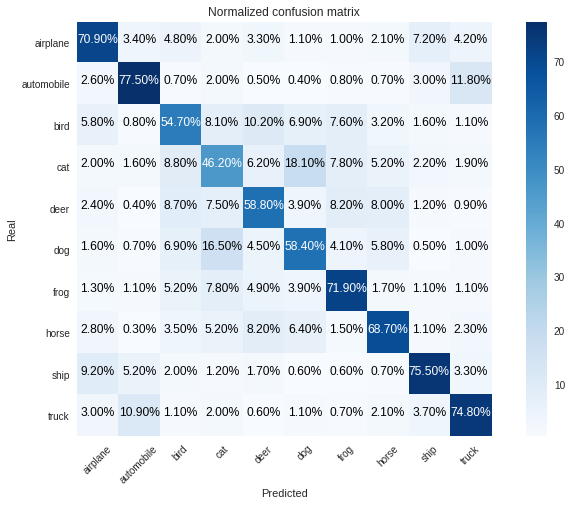

Precision, Recall and F1:


In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score

def res_evaluation(predictions, average_="micro"):
    labels = predictions["labels"]
    pred = predictions["classes"]
    f1_ = f1_score(pred, labels, average=average_)
    precision_ = precision_score(pred, labels, average=average_)
    recall_ = recall_score(pred, labels, average=average_)

    return precision_, recall_, f1_

def train(params = None, use_data_aug=True):
    !rm -r ./tensorboard/cifar10_vgg16
    if params is None:
      params = Hyperparameters()
      
    tf.reset_default_graph()

    train_data, train_labels = utils.get_data_set("train")
    
    if use_data_aug:
        train_data, train_labels = utils.data_augmentation(train_data, train_labels)
    
    print(np.shape(train_data))
    test_data, test_labels = utils.get_data_set("test")  
    
    model = transfer_learning_model(params, params.fine_tunning, params.bottleneck)

    steps_per_epoch = int(math.ceil(len(train_data) /  params.batch_size))
    sess = create_monitored_session(model,steps_per_epoch, params.check_points_path)
    
    
    if (not params.fine_tunning) and params.bottleneck:
        indices = list( range(len(train_data)) )
        shuffle(indices)
        
        shuffled_data = train_data[indices]
        shuffled_labels = train_labels[indices]
        
        bottleneck_train = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_train".format(params.cut_layer), shuffled_data, shuffled_labels)
        bottleneck_test = utils.get_or_generate_bottleneck(sess, model, "bottleneck_vgg16_{}_test".format(params.cut_layer), test_data, test_labels)
        
        train_data, train_labels  = bottleneck_train["data"], bottleneck_train["labels"]
        test_data, test_labels = bottleneck_test["data"], bottleneck_test["labels"]
        del bottleneck_train, bottleneck_test
        
        input_data_placeholder = model["bottleneck_input"]
        
    else:
        input_data_placeholder = model["images"]
        
        
    
    indices = list( range(len(train_data)) )
    msg = "--> Global step: {:>5} - Last batch acc: {:.2f}% - Batch_loss: {:.4f} - ({:.2f}, {:.2f}) (steps,images)/sec"
    
    for epoch in range(params.num_epochs):
        start_time = time()
        
        print("\n*************************************************************")
        print("Epoch {}/{}".format(epoch+1,params.num_epochs))
        
        shuffle(indices)  
        for s in range(steps_per_epoch):
          
            indices_next_batch = indices[s *  params.batch_size : (s+1) * params.batch_size]
            batch_data = train_data[indices_next_batch]
            batch_labels = train_labels[indices_next_batch]
            _, batch_loss, batch_acc,step = sess.run(
                [model["optimizer"], model["loss"], model["accuracy"], model["global_step"],],
                feed_dict={input_data_placeholder: batch_data, model["labels"]: batch_labels, model["keep"]:params.keep})
            #print("loss", batch_loss)
            #print("acc", batch_acc)
        duration = time() - start_time
          
        print(msg.format(step,  batch_acc*100, batch_loss, (steps_per_epoch / duration), (steps_per_epoch*params.batch_size / duration) ))

        
        _ = test(sess, model, input_data_placeholder, test_data, test_labels )
    
    predictions = test(sess, model, input_data_placeholder, test_data, test_labels)
    
    print(res_evaluation(predictions))
    sess.close()
    
    class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"] 
    utils.generate_confusion_matrix(predictions, class_names)


    
params = Hyperparameters()
params.num_epochs = 25
params.cut_layer = "pool4"
params.fine_tunning = True
train(params, use_data_aug = False)

## Exe. 4
A técnica do ** *batch normalization* ** ([artigo original](https://arxiv.org/pdf/1502.03167.pdf)) serve principalmente para acelerar o treinamento da rede. Assim, acrescente essa camada de normalização às camadas totalmente conectadas e disculta os resultados.

**Obs.:  **
* Não utilize a função "tf.layer.dense" do tensorflow. A camada deve ser acrescentada às funções já existentes no código disponível. 
* A ordem das camadas é de fundamental importância para que a técnica seja empregada corretamente. A inserção da camada em uma ordem inexata implicará na incorretude da sua utilização.


# Resposta

* A normalização nas camadas fully connected permitem que a learning rate seja calibrada com números mais altos, aumentando a performance do sistema. Isso ocorre pois os resultados saem da distribuição de saida para uma centrada no ponto 0, comumente chamado de "shift". Após este processo, através da aplicação de tf.nn.relu() no layer, todos os valores menores que zero são desconsiderados.

rm: cannot remove './tensorboard/cifar10_vgg16': No such file or directory
(50000, 32, 32, 3)
Dropout was disabled.
Batch normalization enabled

*************************************************************
Epoch 1/25
--> Global step:   390 - Last batch acc: 43.75% - Batch_loss: 86438.7969 - (26.78, 3427.78) (steps,images)/sec
--> Test accuracy: 37.66% (3766/10000)

*************************************************************
Epoch 2/25
--> Global step:   781 - Last batch acc: 42.50% - Batch_loss: 68702.6484 - (28.91, 3700.15) (steps,images)/sec
--> Test accuracy: 48.59% (4859/10000)

*************************************************************
Epoch 3/25
--> Global step:  1172 - Last batch acc: 53.75% - Batch_loss: 61134.4492 - (28.76, 3681.30) (steps,images)/sec
--> Test accuracy: 53.88% (5388/10000)

*************************************************************
Epoch 4/25
--> Global step:  1563 - Last batch acc: 56.25% - Batch_loss: 35196.5742 - (28.84, 3691.10) (steps,images)/sec

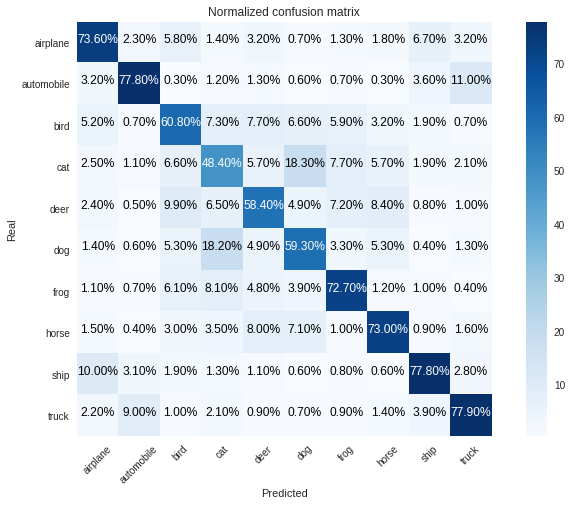

Precision, Recall and F1:


In [14]:
def get_vgg16(input_images, cut_layer = "pool5", scope_name = "vgg16", fine_tunning = False):
    file_name = 'vgg16-20160129.tfmodel'
    main_directory = "./models/"

    vgg_path = os.path.join(main_directory,file_name)
    if not os.path.exists(vgg_path):
        vgg16_url = "https://media.githubusercontent.com/media/pavelgonchar/colornet/master/vgg/tensorflow-vgg16/vgg16-20160129.tfmodel"
        utils.maybe_download_and_extract(vgg16_url, main_directory, file_name, file_name)


    with open(vgg_path, mode='rb') as f:
        content = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(content)
        graph_def = tf.graph_util.extract_sub_graph(graph_def, ["images", cut_layer])
        tf.import_graph_def(graph_def, input_map={"images": input_images})
    del content

    graph = tf.get_default_graph()
    vgg_node = "import/{}:0".format(cut_layer)


    vgg_trained_model = graph.get_tensor_by_name("{}/{}".format(scope_name, vgg_node) )

    if not fine_tunning:
        print("Stopping gradient")
        vgg_trained_model = tf.stop_gradient(vgg_trained_model) #Just use it in case of transfer learning without fine tunning

    return vgg_trained_model, graph

def transfer_learning_model(params = None, fine_tunning = False, bottleneck = False):
   
    if params is None:
       params = Hyperparameters()
      
    with tf.name_scope('placeholders_variables'):
        input_images = tf.placeholder(tf.float32, shape=[None,params.image_size, params.image_size, params.image_channels], name='input')
        labels = tf.placeholder(tf.float32, shape=[None, params.num_classes], name='labels')
        dropout_keep  =  tf.placeholder(tf.float32, name='dropout_keep')
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(params.initial_learning_rate, global_step, params.decay_steps,params.decay_rate, staircase=True)

    with tf.name_scope('vgg16'):
        vgg16_out,_ = get_vgg16(input_images=input_images,cut_layer = params.cut_layer, fine_tunning = fine_tunning)

    with tf.name_scope("flatten"):
        flatten = tf.layers.flatten(vgg16_out, name="flatten")
    
    if (not fine_tunning) and bottleneck:
        out_list = flatten.shape.as_list()
        BOTTLENECK_TENSOR_SIZE = np.prod(out_list[1:]) # All input layer size, less the batch size
        with tf.name_scope('bottleneck'):
            bottleneck_tensor = flatten
            bottleneck_input = tf.placeholder(tf.float32,
            shape=[None, BOTTLENECK_TENSOR_SIZE],
            name='InputPlaceholder')

        with tf.name_scope('fully_conn'):
             logits = fc_model(bottleneck_input, params.hidden_layers) 

    else:
        with tf.name_scope('fully_conn'):
             logits = fc_model(flatten, params.hidden_layers) #Create a fully connected model that will be fed by the vgg16

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(regularize(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels), type_ = 2))
        tf.summary.scalar("loss", loss)

    with tf.name_scope('sgd'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    with tf.name_scope('train_accuracy'):
        acc = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        acc = tf.reduce_mean(tf.cast(acc, tf.float32))
        tf.summary.scalar("accuracy", acc)
   
    
    predictions = {
                "classes": tf.argmax(logits, 1),
                "probs" :  tf.nn.softmax(logits), 
                "labels": tf.argmax(labels, 1)
                }
    model = {
            "global_step": global_step,
            "images": input_images,
            "labels": labels,    
            "loss" : loss,
            "optimizer": optimizer,
            "accuracy": acc,
            "predictions":predictions,
            "keep": dropout_keep
        }

    if (not fine_tunning) and bottleneck:
        model.update({"bottleneck_tensor":bottleneck_tensor})
        model.update({"bottleneck_input":bottleneck_input})
          
    return model
        
def get_fc_weights(w_inputs, w_output, id=0):
    weight= tf.Variable(tf.truncated_normal([w_inputs, w_output]), name="{}/weight".format(id))
    bias =  tf.Variable(tf.truncated_normal([w_output]), name="{}/bias".format(id))
    return weight, bias  

def logits_layer(fc_layer, n_classes):
    out_shape = fc_layer.shape.as_list()
    w, b = get_fc_weights(np.prod(out_shape[1:]), n_classes, "logits/weight")
    logits = tf.add(tf.matmul(fc_layer, w), b, name="logits")
    return logits
      
def fc_layer(input_layer, number_of_units, keep = None, layer_id = "fc", b_norm = True):
    pl_list = input_layer.shape.as_list()
    input_size = np.prod(pl_list[1:])

    w, b = get_fc_weights(input_size, number_of_units, layer_id)  
    fc_layer = tf.matmul(input_layer, w, name="{}/matmul".format(layer_id))
    fc_layer = tf.nn.bias_add(fc_layer, b, name="{}/bias-add".format(layer_id))

    if keep is not None:
        fc_layer = tf.nn.dropout(fc_layer, keep, name="{}/dropout".format(layer_id))
    else:
        print("Dropout was disabled.")
    
    if b_norm:
        print("Batch normalization enabled.")
        fc_layer = tf.layers.batch_normalization(fc_layer)

    fc_layer = tf.nn.relu(fc_layer, name="{}/relu".format(layer_id))
    return fc_layer
      
def regularize(loss, type_ = 1, scale = 0.005, scope = None):
    if type == 1:
        regularizer = tf.contrib.layers.l1_regularizer( scale=scale, scope=scope)
    else:
        regularizer = tf.contrib.layers.l2_regularizer( scale=scale, scope=scope)

    weights = tf.trainable_variables() # all vars of your graph
    regularization_penalty = tf.contrib.layers.apply_regularization(regularizer, weights)
    regularized_loss = loss + regularization_penalty
    return regularized_loss

def fc_model(flatten, hidden_layers = [512], keep = None):
    fc = flatten
    id = 1
    for num_neurons in hidden_layers:
        fc = fc_layer(fc, num_neurons, keep,  "fc{}".format(id) )
        id = id+1

    logits = logits_layer(fc, params.num_classes)
    return logits

def create_monitored_session(model,iter_per_epoch, checkpoint_dir):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    sess = tf.train.MonitoredTrainingSession(checkpoint_dir=checkpoint_dir, save_checkpoint_secs=120, log_step_count_steps=iter_per_epoch, save_summaries_steps=iter_per_epoch, config=config) 
    return sess

params = Hyperparameters()
params.num_epochs = 25
params.keep = None
params.hidden_layers = [1024]
params.cut_layer = "pool4"
params.fine_tunning = True
train(params, use_data_aug=False)

##Exe. 5
1. Baixe uma base de dados da sua preferência que represente um problema de classificação de images.
 * Não pode ser MNIST, Cifar10 ou Cifar100
 * Atente para o tamanho da base de dados. Lembre-se que bases pequenas, muito provavelmente, implicará em *over fitting*.
 
2. Descreva as principais características da base utilizada.
 
3. Aplique os conhecimento aqui adquiridos para alcançar o melhor resultado de classificação.
 * Podem ser utilizados quaisquer conhecimentos ou técnicas adquiridas em outros cursos ou mesmo na internet. Desde que seja possível utilizá-las juntamente com os códigos disponibilizados.

4. Apresente os resultados na forma das 4 métricas implementadas  anteriormente, ademais de uma matriz de confusão.
 *  Escolha uma das métricas para avaliar a qualidade do modelo

5. Explique qual a influência dos hiperparâmetros na solução apresentada.

6. Discuta os resultados apresentados na matriz de confusão, de maneira que seja possível identificar quais as classes que mais influenciaram o resultado, positiva e negativamente.

7. Compare o seu resultado com aqueles já obtidos em outros trabalhos.
 
  * Se a base de dados for própria, e não tiver nenhum outro resultado anterior, não precisa fazer este item.
  
8. Sugira possíveis melhorias que possam ser feitas para melhorar futuramente os resultados.








In [2]:
from  scipy import io as spio
import os
from random import shuffle
from urllib.request import urlretrieve
import tarfile
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import f1_score, precision_score, recall_score

%matplotlib inline


tf.reset_default_graph()

# visualize image
def visualize_digit(data , sample):
    img = data[sample]
    print(np.shape(img))
    plt.imshow(img[0], cmap='gray')
    
def dense_to_one_hot( labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

    return labels_one_hot

def load_data(url):
    fname = "emnist.zip"
    if not os.path.isfile(fname):
        url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
        file_path, _ = urlretrieve(url, "emnist.zip")
    if not os.path.exists("matlab/"):
        !unzip emnist.zip
    emnist = spio.loadmat("matlab/emnist-byclass.mat")
    return emnist
  
def res_evaluation(pred, labels, average_="micro"):
    f1_ = f1_score(pred, labels, average=average_)
    precision_ = precision_score(pred, labels, average=average_)
    recall_ = recall_score(pred, labels, average=average_)
    return precision_, recall_, f1_

url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
batch_size = 3072
num_epochs = 50

emnist = load_data(url)


#load train
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

y_train = emnist["dataset"][0][0][0][0][0][1]

n_classes = len(np.unique(y_train))
y_train = dense_to_one_hot(y_train, n_classes)


# load test
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

y_test = dense_to_one_hot(emnist["dataset"][0][0][1][0][0][1], n_classes)


#x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
#x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")


x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, n_classes])


x_image = tf.reshape(x, [-1,28,28,1])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
  
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])

b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])

b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, n_classes])
b_fc2 = bias_variable([n_classes])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = tf.reduce_sum(y_*tf.log(y_conv))

train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
                                                             
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

steps_per_epoch = int(math.ceil(len(x_train) / batch_size))
print(len(y_train), len(y_test))
print("steps", steps_per_epoch)


indices = list( range(len(x_train)) )
shuffle(indices)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):

        print("\n*************************************************************")
        print("Epoch {}/{}".format(epoch+1, num_epochs))

        
        for s in range(steps_per_epoch):
            indices_next_batch = indices[s *  batch_size : (s+1) * batch_size]
            batch_data = x_train[indices_next_batch]
            batch_labels = y_train[indices_next_batch]


            sess.run(train_step,feed_dict={x: batch_data, y_: batch_labels, keep_prob: 0.5})    

        train_accuracy = sess.run(accuracy, feed_dict={ x:batch_data, y_: batch_labels, keep_prob: 1.0})
        print("training accuracy %g"%(train_accuracy))
        test_idx = list( range(len(x_train)))
        shuffle(test_idx)
        print("test accuracy %g"% sess.run(accuracy, feed_dict={x: x_test[test_idx[:10000]], y_: y_test[test_idx[:10000]], keep_prob: 1.0}))

# Relatório

O dataset escolhido foi o [EMNIST](https://www.nist.gov/srd/nist-special-database-19), sendo composto por 697.932 imagens de treinamento e 116.323 de teste. Tal qual o MNIST, são imagens 128 x 128 que *a priori* são transformadas em dados 28 x 28. Este dado contém 62 classes, sendo 10 dígitos, 26 letras maiúsculas e 26 minúsculas.

O EMNIST tem uma complexidade muito maior se comparado com o dataset tradicional. Devido a sua grande variabilidade, é necessário tornar a rede uma especialista no reconhecimento de cada um dos 62 tipos diferentes de caracteres. A diferença entre letras maiúsculas e minúsculas torna-se uma tarefa ainda mais difícil de ser tratada.

Um método foi proposto por [Cohen 2017](https://arxiv.org/pdf/1702.05373v1.pdf) e publicado no *2017 International Joint Conference on Neural Networks (IJCNN)*. A *accuracy* no teste de reconhecimento das classes é de aproximadamente  69.71% com o *OPIUM Classifier*, caracterizando essa complexidade do problema.

A tentativa foi utilizar os mesmos aspectos utilizados na classificação do dataset de dígitos para todas as classes, avaliando como é dado seu reconhecimento. Os resultados obtidos nos experimentos não alcançam os resultados da literatura, sendo necessários trabalhos futuros na capacidade de generalização do sistema.